# PCA on synthetic data

In [0]:
import numpy as np

Run this cell to generate and display our synthetic data.

Imagine that you are only given the rotated data, and would like to find the angle by which it has been rotated. We can do this by identifying the principal directions !

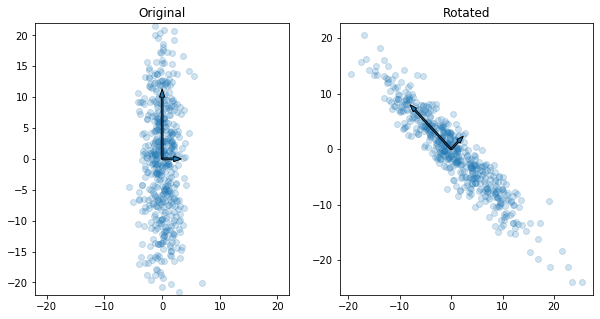

In [0]:
from matplotlib import pyplot as plt
import torch
import math

cov = torch.FloatTensor([
    [2, 0],
    [0, 10]
])
# generate the original data
data = torch.randn(500, 2) @ cov
plt.figure(figsize=(10, 5))
plt.subplot(121)
orig = plt.scatter(data[:, 0], data[:, 1] ,alpha=0.2)
plt.xlim([-22, 22])
plt.ylim([-22, 22])
plt.title("Original")


directions = torch.FloatTensor([
    [0, 10],
    [2, 0]
])


a = plt.arrow(0, 0, 0, 10, width=0.3)
plt.arrow(0, 0, 2, 0, width=0.3, facecolor=a.get_facecolor())

# generate a random rotation of this data
theta = torch.FloatTensor([math.pi / 4])
rotation_matrix = torch.FloatTensor([
    [torch.cos(theta), torch.sin(theta)],
    [-torch.sin(theta), torch.cos(theta)]
])
rotated_directions = directions @ rotation_matrix
rotated_data = data @ rotation_matrix
plt.subplot(122)
rotated = plt.scatter(rotated_data[:, 0], rotated_data[:, 1],alpha=0.2)

b = plt.arrow(0, 0, rotated_directions[0, 0], rotated_directions[0, 1], width=0.3)
plt.arrow(0, 0, rotated_directions[1, 0], rotated_directions[1, 1], width=0.3, facecolor=b.get_facecolor())
plt.title("Rotated")
plt.show()

Here, we generated the data, so we know what rotation we applied. Now imagine that you were only given the rotated data (the *rotated_data* tensor) and you want to retrieve the angle of the rotation $\theta$.

We can do this by identifying the principal directions using the PCA !


Let $X\in\mathbb{R}^{N\times d}$ be a centered dataset. Then $\Sigma=\frac{1}{N}X^\top X$ is its empirical covariance.

The [Eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of this matrix reveals the _principal directions_ of the dataset.

For $\Sigma=U\cdot\textrm{Diag}(S)\cdot U^\top$. The principal directions are the columns of $U$, while the strength of these directions are represented by $S$.


In the next cell:
- compute the empirical covariance and its eigendecomposition (use [symeig](https://pytorch.org/docs/stable/torch.html#torch.symeig)).
- display the directions (the two columns of $U$) multiplied by the corresponding values in $\sqrt{S}$.

In the following, we will see different, practical uses of the PCA.

In [0]:
X = rotated_data
emperical_cov = (X.T@X)/float(X.shape[0])
S, U = torch.symeig(emperical_cov, eigenvectors=True)

In [0]:
print(U.shape)
print(S.shape)
print(emperical_cov.shape)

torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])


In [0]:
print(S)
print(U)

tensor([  3.3716, 100.9696])
tensor([[-0.7026, -0.7116],
        [-0.7116,  0.7026]])


In [0]:
new_directions = (torch.sqrt(S) *  U.T).T


In [0]:
print(new_directions)

tensor([[-1.2902, -1.3066],
        [-7.1500,  7.0602]])


In [0]:
print(U[:, 0] * torch.sqrt(S[0]))
print(U[:, 1] *  torch.sqrt(S[1]))
print(U * torch.sqrt(S))

tensor([-1.2902, -1.3066])
tensor([-7.1500,  7.0602])
tensor([[-1.2902, -7.1500],
        [-1.3066,  7.0602]])


In [0]:
print(new_directions)

tensor([[-1.2902, -1.3066],
        [-7.1500,  7.0602]])


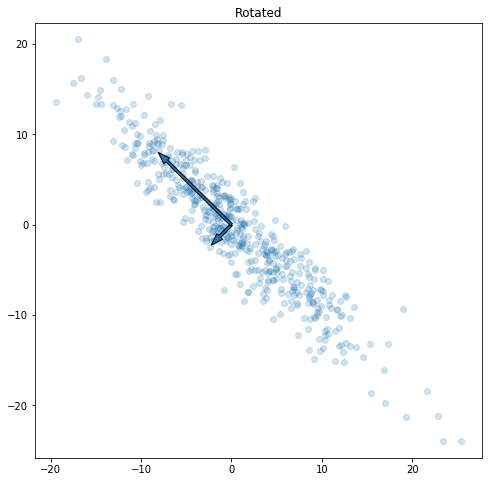

In [0]:
plt.figure(figsize=(8, 8))

rotated = plt.scatter(rotated_data[:, 0], rotated_data[:, 1],alpha=0.2)

plt.arrow(0, 0, new_directions[0, 0], new_directions[0, 1], width=0.3, facecolor=b.get_facecolor())
plt.arrow(0, 0, new_directions[1, 0], new_directions[1, 1], width=0.3, facecolor=b.get_facecolor())
plt.title("Rotated")
plt.axis("equal")
plt.show()

# MNIST

MNIST is a dataset containing images of digits from 0 to 9. Due to its small size, it is very fast to test ideas on MNIST.

MNIST contains grayscale images of size $28 \times 28$. This means that each element of the MNIST dataset is an element of $\mathbb{R}^{784}$.

If we want to visualize the entire dataset, we need to somehow transform it by mapping $\mathbb{R}^{784}$ to $\mathbb{R}^2$.

We will see two ways of obtaining such mappings.

## The dataset

Run this cell. The first call to dataset will download the data and build a torch Dataset object.

The two last lines build a first tensor of size $N \times 784$ containing all (flattened) images, and a second tensor containing the digit associated to these images.

In [0]:
import torch
from torchvision import datasets, transforms

dataset = datasets.MNIST('../data', train=True, download=True,
  transform=transforms.Compose([
    transforms.ToTensor()
  ])
)

all_examples = torch.cat([x[0] for x in dataset], 0).view(len(dataset), -1)
all_labels = torch.LongTensor([x[1] for x in dataset])

In the next cell, display the first element of all_examples and verify that it matches the first element of all_labels.

Remember that the images are flattened !

Before you can display them with implot, you need to use [view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) to reshape them to a size of $28 \times 28$.

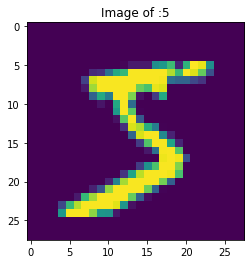

In [0]:
plt.imshow(all_examples[0].view(28, 28))
plt.title("Image of :{}".format(all_labels[0]))
plt.show()

## Linear dimensionality reduction : PCA
In the next cell **(using only the first 500 elements of the dataset)**:
- compute the empirical covariance and its eigendecomposition (use [symeig](https://pytorch.org/docs/stable/torch.html#torch.symeig)). (Be careful, this time the data is not centered !)
- Plot the eigenvalues cumulative distribution (use [cumsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html)) : $$cs(i) = \frac{\sum_{j=1}^i s_j}{\sum_{j=1}^n s_j}$$.
- Find the number of eigenvalues required such that $\sum_{j=1}^i s_j$ makes up more than $80\%$ of the spectrum. (you can use [searchsorted](https://docs.scipy.org/doc/numpy/reference/generated/numpy.searchsorted.html) for this)

The cumulative distribution represents the  **explained variance**. If it goes up to $1$ very quickly, then there is a good chance that the PCA will yield interesting results ! 

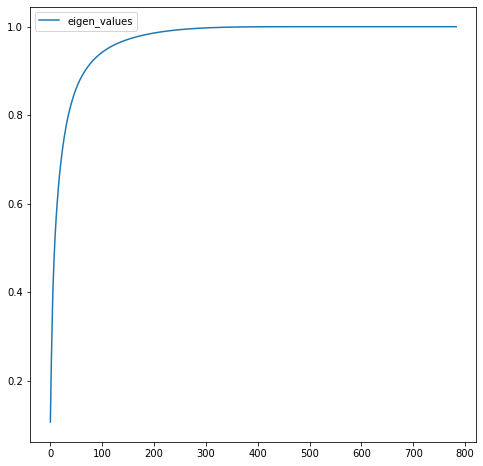

Number of eigen vectors needed to get 80% of the spectrum is : 35


In [0]:
# reduce the dataset to first 500 points :
new_examples = all_examples[:500]
new_labels = all_labels[:500]
# compute the mean and center this new dataset:
mean_of_examples = torch.mean(new_examples, axis=0)
centered_examples = new_examples - mean_of_examples

# compute the empirical covariance, using the centered dataset
cov = (centered_examples.T @ centered_examples)/centered_examples.shape[0]
# get s and u with torch.symeig
S, U  = torch.symeig(cov, eigenvectors=True)

cum_sum = np.cumsum(S.numpy()[::-1])
cum_sum_norm = cum_sum/cum_sum[-1]
# plot the cumulative distribution of the eigenvalues in s 
plt.figure(figsize=(8, 8))
plt.plot(cum_sum_norm, label="eigen_values")
plt.legend()
plt.show()
# find the number of eigenvalues required to get 80% of the spectrum
index = np.searchsorted(cum_sum_norm, 0.8)
print("Number of eigen vectors needed to get 80% of the spectrum is : {}".format(index.item()))


Project the first 500 examples of the dataset on the top 2 eigenvectors of the empirical covariance.

To do this multiply your data by the matrix containing the two last columns in $U$. (bonus : Can you explain why ?)


Use a scatter plot to display this projected dataset, coloring the points using the labels.

Are the different labels well separated ?

In [0]:
projected_data = centered_examples.numpy() @ (U[:, -2:].numpy()[:, ::-1])

Line2D()


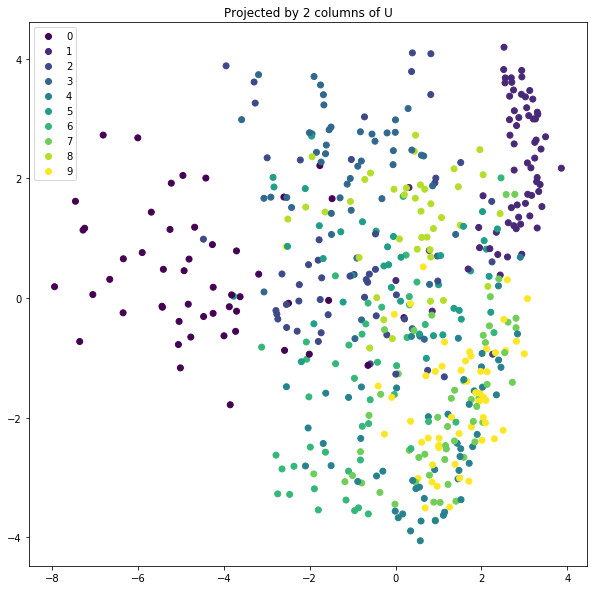

In [0]:
plt.figure(figsize=(10, 10))
plt.title("Projected by 2 columns of U")
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=new_labels.numpy())
print(scatter.legend_elements()[0][0])
plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(new_labels.numpy()).tolist())

plt.show()

In [0]:
cov_orignal = (all_examples[:500].T @ all_examples[:500])/all_examples[:500].shape[0]
# get s and u with torch.symeig
S_o, U_o  = torch.symeig(cov_orignal, eigenvectors=True)
projected_data_o = all_examples[:500].numpy() @ (U_o[:, -2:].numpy()[:, ::-1])

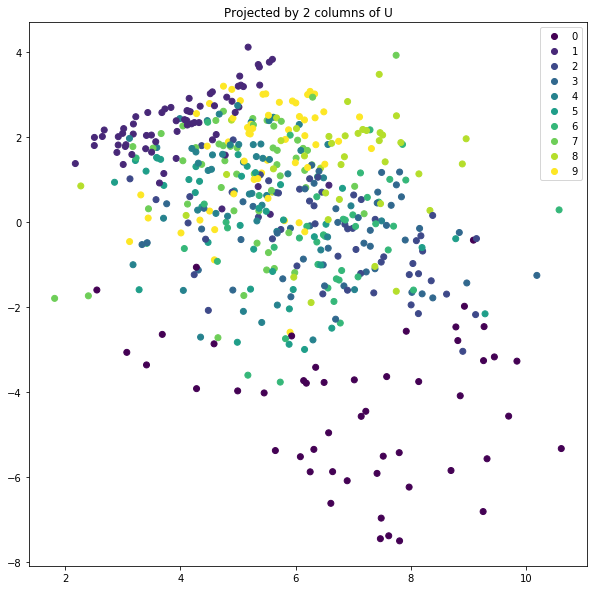

In [0]:
plt.figure(figsize=(10, 10))
plt.title("Projected by 2 columns of U")
scatter = plt.scatter(projected_data_o[:, 0], projected_data_o[:, 1], c=all_labels[:500].numpy())

plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(all_labels[:500].numpy()).tolist())

plt.show()

The same thing can be done with scikit learn using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Let's use this cell to encapsulate our plot method.

In [0]:
from sklearn import decomposition
def display_mnist(reduced, labels):
  """ Displays a colored scatter plot of the reduced labels.
    params : reduced is a numpy array of size N x 2 containing the points to plot
             labels is a numpy array containing the labels
  """
  
  # fill this function 
  pca = decomposition.PCA(n_components=2)
  projected = pca.fit_transform(reduced)
  plt.figure(figsize=(8, 8))
  plt.title("MNIST data projected to 2D")
  for i in range(10):
    current_points = projected[labels==i]
    plt.scatter(current_points[:, 0], current_points[:, 1], label=str(i))
  plt.legend()
  plt.show()
  # use scikit learn to compute the data projected to its two principal directions

Try to compute the PCA without centering the dataset first. What happens ?

The principal directions can be interpreted as images themselves, let's display them.

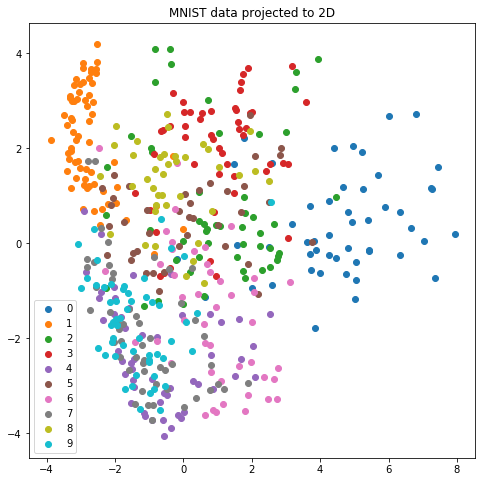

In [0]:
display_mnist(all_examples[:500], all_labels[:500])

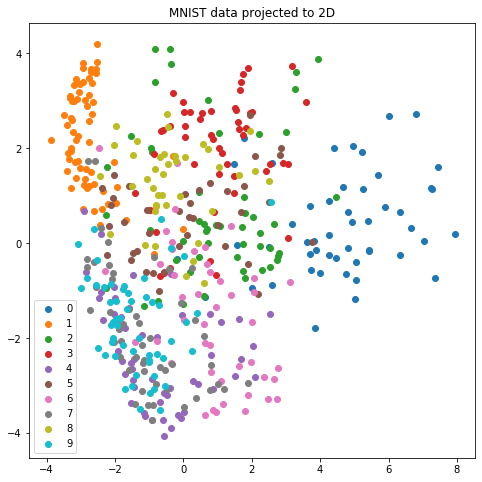

In [0]:
display_mnist(centered_examples[:500], all_labels[:500])

In [0]:
image_data =  [100]

## PCA on learned representations

In a neural network, recall that the output of each intermediate layer can be considered as a new **representation** of the data.

Since the last layer of the network is a **linear classifier**, we expect the representation at this last layer to be linearly separable.

In the next cell :
- Complete the training code of the neural net on MNIST. Test with a smaller dataset first ! When you are convinced that everything is good, learn your model on the entire dataset. Display the training loss, this is what you should observe.

```
Train Epoch: 0 	Loss: 0.281004
Train Epoch: 1 	Loss: 0.095250
Train Epoch: 2 	Loss: 0.075834
```





In [0]:
import torch.nn.functional as F
from torch import nn
from torch import optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

device = 'cuda:0'

model = Net().to(device)

train_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=128, shuffle=True, num_workers=1, pin_memory=True
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
# train for 10 epochs
epochs_losses = []
for i in range(10):
  # iterate over train_loader
  step_losses = []
  for index, (data, target) in enumerate(train_loader):
    # use F.nll_loss as your loss
    optimizer.zero_grad()
    loss = F.nll_loss(model(data.to(device)), target.to(device))
    step_losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
  mean_loss = np.mean(step_losses)
  epochs_losses.append(mean_loss)
  print("Train Epoch: {}     Loss: {}".format(i, mean_loss))
  # display avergage training loss over the last epoch


Train Epoch: 0     Loss: 0.29416727776657037
Train Epoch: 1     Loss: 0.09317686699473782
Train Epoch: 2     Loss: 0.07406321397102845
Train Epoch: 3     Loss: 0.06189234768038492
Train Epoch: 4     Loss: 0.05727761581357418
Train Epoch: 5     Loss: 0.051742986390696785
Train Epoch: 6     Loss: 0.047720608335218705
Train Epoch: 7     Loss: 0.041442129234753565
Train Epoch: 8     Loss: 0.03829297177525345
Train Epoch: 9     Loss: 0.03539408681624289


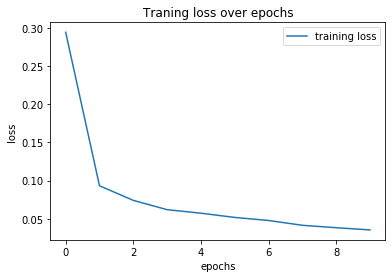

In [0]:
plt.figure()
plt.title("Traning loss over epochs")
plt.plot(epochs_losses, label="training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Define a function that applies the neural net (without dropout) we've learned to a batch of examples, and returns all intermediate representations.


Using the reduced dataset used earlier, display a PCA of each of the intermediate representations, what do you notice ?

In [0]:
def transform(model, x):
    """
        parameters :
            - model : learned Net
            - x : torch.Tensor of shape batch x  784
        returns :
            - dictionary containing x after the first, second and third layers of the Net.
    """
    model.eval()
    first = F.relu(model.conv1(x.view(-1, 1, 28, 28)))
    
    second = F.max_pool2d(model.conv2(first), 2)
   
    second_flatten = torch.flatten(second, 1)
    
    third = F.relu(model.fc1(second_flatten))
    
    # model.
    return {
        'first': first,
        'second': second,
        'third': third
    }

# Then display the PCA for each intermediary representation using display_mnist 

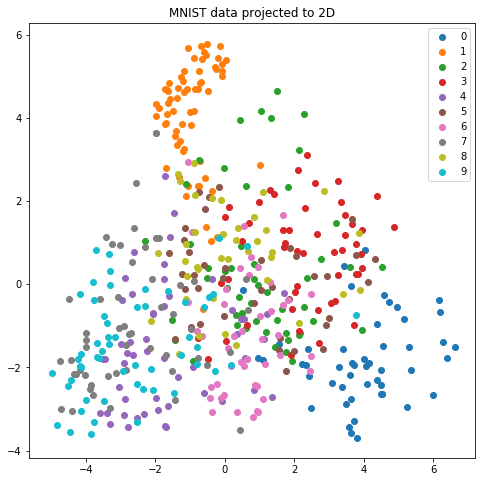

In [0]:
representations = transform(model, new_examples.to(device))
first_rep  = representations["first"].cpu().detach().view(new_examples.shape[0], -1)

display_mnist(first_rep, new_labels)

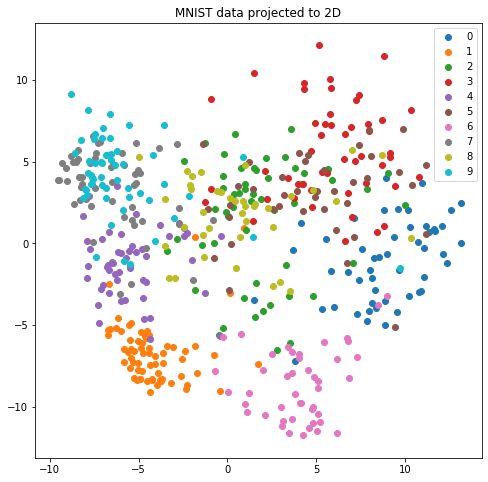

In [0]:
second_rep  = representations["second"].cpu().detach().view(new_examples.shape[0], -1)

display_mnist(second_rep, new_labels)

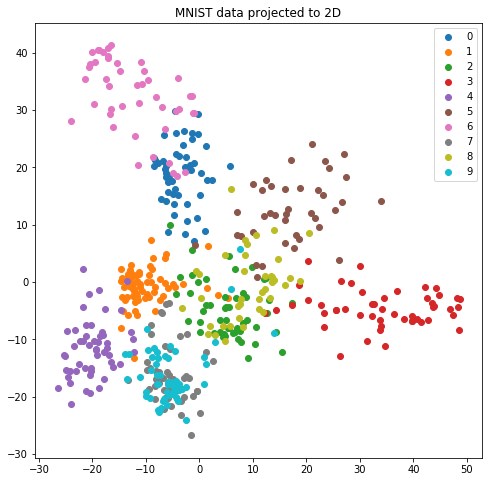

In [0]:
third_rep  = representations["third"].cpu().detach().view(new_examples.shape[0], -1)

display_mnist(third_rep, new_labels)

## Non-Linear dimensionality reduction : T-SNE

T-SNE learns representations of points such that points that are close in the original space will be close in the target space.

It is more flexible than the PCA, since the transformation isn't necessarily linear.

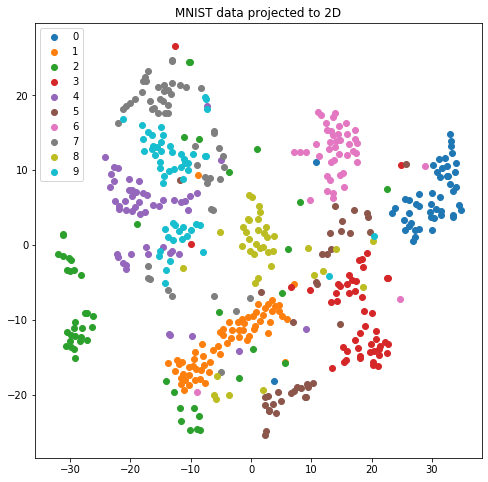

In [0]:
from sklearn.manifold import TSNE

transformed = TSNE(n_components=2).fit_transform(new_examples)
display_mnist(transformed,new_labels)

Not too bad, clusters appear more clearly than in the PCA visualization. Remember that this is completely unsupervised, the only information represented in a T-SNE plot is the nearest neighbors of each points.

In the next cell, plot the T-SNE representations for the intermediate layer of our neural net. 

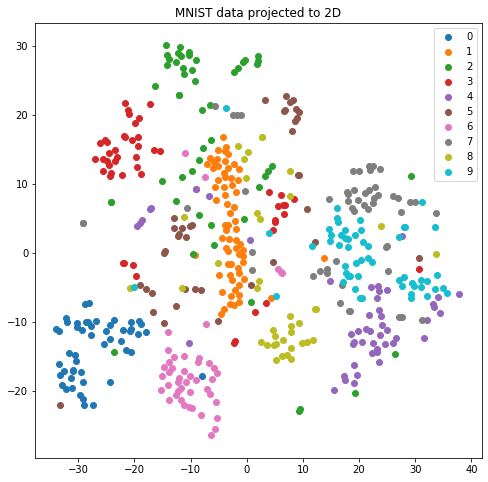

In [0]:
transformed_first = TSNE(n_components=2).fit_transform(first_rep)
display_mnist(transformed_first,new_labels)

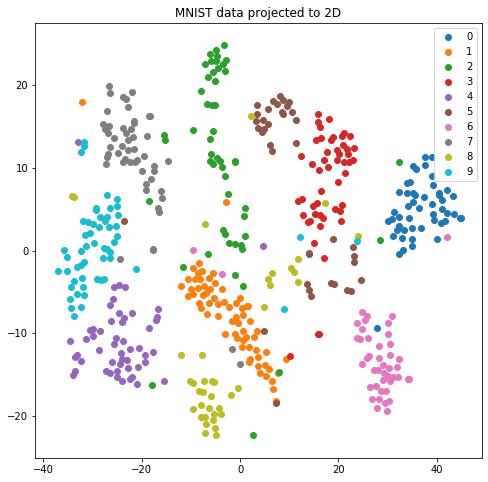

In [0]:
transformed_second = TSNE(n_components=2).fit_transform(second_rep)
display_mnist(transformed_second,new_labels)

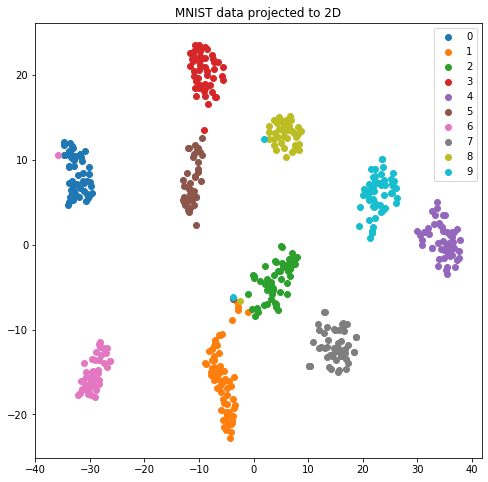

In [0]:
transformed_third = TSNE(n_components=2).fit_transform(third_rep)
display_mnist(transformed_third,new_labels)

# Word vectors

Word vectors often come up in NLP applications. They are learned by trying to predict a word given it's context. This means that words that occur in similar context will have similar representations. Let's observe these representations with our two tools : PCA and t-SNE.

Start by loading [FastText](https://fasttext.cc/) words embeddings for 1M english words. To do this, click on [this link](https://drive.google.com/open?id=18dNzJTW2w8kLDvOmNFn7-pFEYHAHNVyN) to add a folder called _AMMI_DIY_ to your google drive. Then in the menu on the left of the colab notebook, go to file and click on  _Mount Drive_. Follow the instructions.



Once the drive is loaded, we load the embeddings in the next cell. What python type is _embeddings_ ? What does it contain ?

In [0]:
%ls

drive/  sample_data/


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
embeddings = torch.load('drive/My Drive/AMMI_DIY/session_2/embeddings.torch')


In [0]:
print(type(embeddings))

<class 'dict'>


Now let's plot a PCA of all words

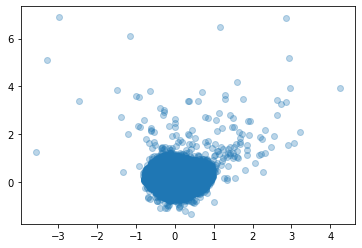

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
transformed = PCA(n_components=2).fit_transform(embeddings['vectors'])

plt.figure()
plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.3)
plt.show()

Not great. Two dimensions are not enough to describe the variety of one million words.

Let's work with less words.

Load a list of countries and capitals. Build an array containing all vectors corresponding to either countries or capitals. Ignore those that aren't in the loaded word vectors.


In [0]:
f = open('drive/My Drive/AMMI_DIY/session_2/countries_capitals')
to_project = []
pairs = []
for line in f:
    country, capital = [x.strip() for x in line.split('-', 1)]
    
    if country in embeddings['word_id'] and capital in embeddings['word_id']:
        pairs.append((country, len(to_project), capital, len(to_project) + 1))
        word_id = embeddings['word_id'][country]
        to_project.append(embeddings['vectors'][word_id][None, :])

        word_id = embeddings['word_id'][capital]
        to_project.append(embeddings['vectors'][word_id][None, :])

Compute a PCA of these vectors and display a scatter plot. Plot an arrow going from each country to its capital, what do you notice ?

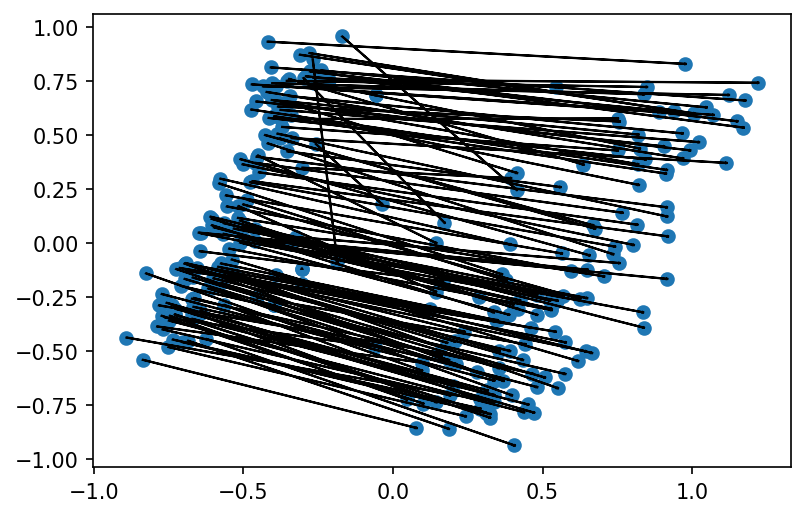

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

full_vectors=torch.cat(to_project)
pca = PCA(n_components=2).fit(full_vectors)
transformed = pca.transform(full_vectors)
plt.figure(dpi=150)
plt.scatter(transformed[:, 0], transformed[:, 1])
for country, id_country, capital, id_capital in pairs:
    start, end = transformed[id_country], transformed[id_capital]
    delta = end - start
    plt.arrow(start[0], start[1], delta[0], delta[1])
plt.show()

But why use a PCA ? Isn't t-SNE strictly better ? Let's try with t-SNE.

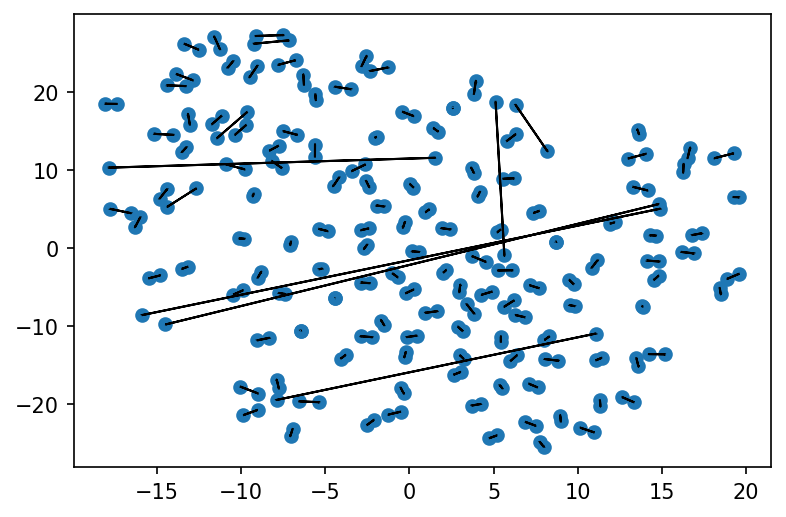

In [0]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

full_vectors=torch.cat(to_project)
transformed = TSNE(n_components=2).fit_transform(full_vectors)

plt.figure(dpi=150)
plt.scatter(transformed[:, 0], transformed[:, 1])
for country, id_country, capital, id_capital in pairs:
    start, end = transformed[id_country], transformed[id_capital]
    delta = end - start
    plt.arrow(start[0], start[1], delta[0], delta[1])
plt.show()

The take away from the two methods are wildly different. From the TSNE plot, we learn that the representation of a capital is close to the representation of its country.

However, letting $U$ be the matrix of word embeddings, with $P$ the projection from the PCA, we see that there exist a vector $v$ such that $$\forall (\textrm{country}, \textrm{capital}), P(U_{\textrm{country}} - U_{\textrm{capital}}) \approx v.$$

**The difference between a country and it's capital is constant and does not depend on the pair chosen !**

This $v$ can be interpreted as the projection of a vector $\tilde{v}$ in the original (non-projected) space. However, since $P$ is not invertible, we have no guarantee that 
$$\forall (\textrm{country}, \textrm{capital}), U_{\textrm{country}} - U_{\textrm{capital}} \approx \tilde{v}.$$

Let's try !
Let $\tilde{v} = U_{Madrid} - U_{Spain}$ and compute $U_{France} + \tilde{v}$, find its 5 nearest neighbors. Try with $U_{Rwanda} + \tilde{v}$. 

In [0]:
normed = embeddings['vectors'] / torch.norm(embeddings['vectors'], 2, 1, keepdim=True)

v = normed[embeddings['word_id']['Madrid']] - normed[embeddings['word_id']['Spain']]
modified_france = normed[embeddings['word_id']['France']] + v

distances = torch.norm(normed - modified_france[None, :], 2, 1)
distances, ids = torch.sort(distances)

for i, d in zip(ids[:5], distances[:5]):
    print(embeddings['words'][i], d)

Paris tensor(0.5785)
France tensor(0.7212)
Madrid tensor(0.7652)
Toulouse tensor(0.8419)
Lille tensor(0.8441)


In [0]:
normed = embeddings['vectors'] / torch.norm(embeddings['vectors'], 2, 1, keepdim=True)

v = normed[embeddings['word_id']['Madrid']] - normed[embeddings['word_id']['Spain']]

modified_rwanda = normed[embeddings['word_id']['Rwanda']] + v

distances = torch.norm(normed - modified_rwanda[None, :], 2, 1)
distances, ids = torch.sort(distances)

for i, d in zip(ids[:5], distances[:5]):
    print(embeddings['words'][i], d)

Rwanda tensor(0.7212)
Kigali tensor(0.8016)
Rwandan tensor(0.9199)
Nairobi tensor(0.9509)
Butare tensor(0.9543)


In the next cell, plot the countries and capitals transformed by a PCA, then also apply the PCA to words in ['Capital', 'Dog', 'Computer', 'Pizza', 'City', 'Country']. What do you notice ?

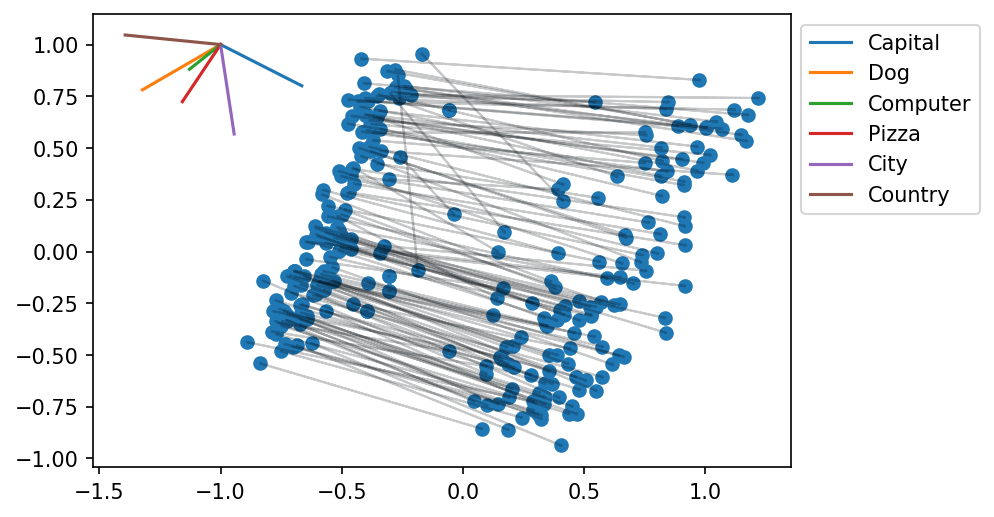

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

full_vectors=torch.cat(to_project)
pca = PCA(n_components=2).fit(full_vectors)
transformed = pca.transform(full_vectors)
words = ['Capital', 'Dog', 'Computer', 'Pizza', 'City', 'Country']
vectors_to_plot = [
    pca.transform(embeddings['vectors'][embeddings['word_id'][x]][None, :])
    for x in words
]
plt.figure(dpi=150)
plt.scatter(transformed[:, 0], transformed[:, 1])
for country, id_country, capital, id_capital in pairs:
    start, end = transformed[id_country], transformed[id_capital]
    delta = end - start
    plt.arrow(start[0], start[1], delta[0], delta[1], alpha=0.2)
for v, w in zip(vectors_to_plot, words):
    x = v[0, 0]
    y = v[0, 1]
    plt.plot([-1, -1 + x], [1, 1 +y], label=w)
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

Since the PCA is simpler, the relations it reveals can be understood mathematically. Here, we've rediscovered that word vectors can be used to answer analogies:
The answer to "A is to B as C is to ..." can be computed by finding the nearest neighbor of $vec(b) - vec(a) + vec(c)$.

# Back to Linear Classification

Since visualizations are in 2D, lots of information is lost. There are other tools to probe the information contained in embeddings.

For example, we can try to learn a linear classifier that separates countries from other words. If we obtain good performances, then we know that there exists a hyperplane in the original space that separates the country words from the others.


First, we load our dataset. It contains a train, validation and test set.

In [0]:
# Reload the embeddings from scratch
import torch
dataset = torch.load('drive/My Drive/AMMI_DIY/session_2/country_classif.torch')

Using [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) **with the hinge loss**, learn a classifier on the train set.

Notice that LinearSVC takes a regularization argument : $C$.

Use the train and validation set to find the best $C$ for this dataset, for the metric defined in the cell below. Our best result is close to 0.96, can you match it ?

In [0]:
C

In [0]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn import metrics

def metric(model, dataset):
    predictions = logistic_regression.decision_function(final_dataset['valid']['vectors'].numpy())
    precision, recall, thresholds = metrics.precision_recall_curve(
        final_dataset['valid']['labels'].numpy(), predictions
    )
    return metrics.auc(recall, precision)    

Since the PCA is linear, we can display the projection of the hyperplane !

In the code below, replace **coeffs** and **intercept** by the corresponding parameters of the best hyper-plane you found using LinearSVC.

In [0]:
# Load a list of countries and capitals.
f = open('drive/My Drive/AMMI_DIY/session_2/countries_capitals')
to_project = []
pairs = []
for line in f:
    country, capital = [x.strip() for x in line.split('-', 1)]
    
    if country in embeddings['word_id'] and capital in embeddings['word_id']:
        pairs.append((country, len(to_project), capital, len(to_project) + 1))
        word_id = embeddings['word_id'][country]
        to_project.append(embeddings['vectors'][word_id][None, :])

        word_id = embeddings['word_id'][capital]
        to_project.append(embeddings['vectors'][word_id][None, :])

# Compute the PCA
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

full_vectors=torch.cat(to_project)
pca = PCA(n_components=2).fit(full_vectors)
transformed = pca.transform(full_vectors)


# Compute the projected hyperplane
w = pca.transform(coeffs[:])

# Compute the segment representing the hyperplane
xx = np.linspace(-1.5, 1.5)
a = -w[0, 0] / w[0, 1]
yy = a * xx - intercept


# Display everything
plt.figure(dpi=150)
plt.scatter(transformed[::2, 0], transformed[::2, 1], label="country")
plt.scatter(transformed[1::2, 0], transformed[1::2, 1], label="capital")
plt.plot(xx, yy, 'r', label="hyperplane")
plt.ylim([-1.5, 1.5])
plt.xlim([-1, 1.5])
plt.legend()
plt.show()

NameError: ignored